# Quantum Teleportation — Concept Overview

Quantum teleportation transfers an unknown qubit state from Alice to Bob using:

* A shared Bell pair (entanglement)
* Measurement by Alice
* Classical communication of measurement results
* Conditional corrections by Bob

The state is not physically moved. Instead, classical information + entanglement recreate the state at Bob's location.

## Quantum Teleportation Circuit Breakdown
This circuit teleports the initial state of Alice's qubit (C) to Bob's qubit (B) using the shared Alice-Bob Bell pair (A-B) and classical communication.

## 1. Import Libraries

In [1]:
#Quantum State with 3 qubits
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.circuit.library import HGate, CXGate, XGate, YGate, ZGate
from math import sqrt

## 2. Create Quantum & Classical Registers

* qC → Alice's unknown qubit
* qA → Alice's half of the Bell pair
* qB → Bob's half of the Bell pair

We also create classical registers cC, cA, CB to store their measurements.

In [2]:
qC=QuantumRegister(1, name="Alice_C") # state to teleport
qA=QuantumRegister(1, name="Alice_A") # part of Bell pair (Alice)
qB=QuantumRegister(1, name="Bob_B") # part of Bell pair (Bob)

cC=ClassicalRegister(1, name="alice_c") # Alice measurement 1
cA=ClassicalRegister(1, name="alice_a") # Alice measurement 2
cB=ClassicalRegister(1, name="bob_b") # Bob measurement 

qc=QuantumCircuit(qC, qA, qB, cC, cA, cB)

## 3. Prepare the Unknown State to Teleport

Example unknown state: $|+⟩ = (|0⟩ + |1⟩)/\sqrt(2)$

In [3]:
#Prepare state Alice's C 
amp=[1/sqrt(2),1/sqrt(2)]
qc.initialize(amp, qC[0])
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Alice_C"), index=0>, <Qubit register=(1, "Alice_A"), index=0>, <Qubit register=(1, "Bob_B"), index=0>), clbits=())

## 4. Create the Bell Pair Between Alice (qA) and Bob (qB)

Alice and Bob establish an entangled pair, typically the $|\Phi^+\rangle$ Bell state, by
* ApplyIing Hadamard on qA → to create superposition
* Applying CNOT between qA → qB → to entangle 

In [4]:
#Creating Bell's pair
qc.append(HGate(), [qA[0]])
qc.append(CXGate(), [qA[0],qB[0]])
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Alice_C"), index=0>, <Qubit register=(1, "Alice_A"), index=0>, <Qubit register=(1, "Bob_B"), index=0>), clbits=())

Resulting State on $qA$ and $qB$:$$|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$

## 5. Alice Performs Bell Measurement

Alice performs the analysis stage on her two qubits: the source qubit ($qC$) and her Bell partner ($qA$). This transforms the overall state into a form where Bob's qubit ($qB$) holds the required state rotation, dependent on Alice's classical measurement results.

She performs operations to project the system into Bell basis:
* CNOT from unknown qubit → Alice's qubit
* Hadamard on unknown qubit.
  
Then she measures both.

In [5]:
#Bell measurement on Alice's C and A states
qc.append(CXGate(), [qC[0],qA[0]])
qc.append(HGate(), [qC[0]])
qc.barrier()

# Measure and send results (classical communication)
qc.measure(qC[0], cC[0])
qc.measure(qA[0], cA[0])
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Alice_C"), index=0>, <Qubit register=(1, "Alice_A"), index=0>, <Qubit register=(1, "Bob_B"), index=0>), clbits=())

## 6. Bob Applies Conditional Corrections (Dynamic Circuit)

Bob receives the two classical bits $(cA, cC)$ and applies a corresponding unitary transformation (rotation) to his qubit ($qB$) to reconstruct the original state $|\psi\rangle$.

Depending on Alice’s measurement results:

* If cA == 1 → apply X
* If cC == 1 → apply Z

This reconstructs the original unknown state.

That is, if
* cA=0, cC =0, apply **I Gate**
* cA=0, cC =1, apply **ZGate**
* cA=1, cC =0, apply **X Gate**
* cA=1, cC =1, apply **ZX Gate**

In [6]:
# Conditional corrections on Bob's qubit
with qc.if_test((cC[0], 1)):
    qc.z(qB[0])
with qc.if_test((cA[0], 1)):
    qc.x(qB[0])
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "Alice_C"), index=0>, <Qubit register=(1, "Alice_A"), index=0>, <Qubit register=(1, "Bob_B"), index=0>), clbits=())

## 7. Bob Measures His Final Qubit

Bob measures his qubit to verify the state. Since the initial state was $|\mathbf{+}\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, the measurement in the computational basis should yield 0 and 1 with approximately $50\%$ probability each.

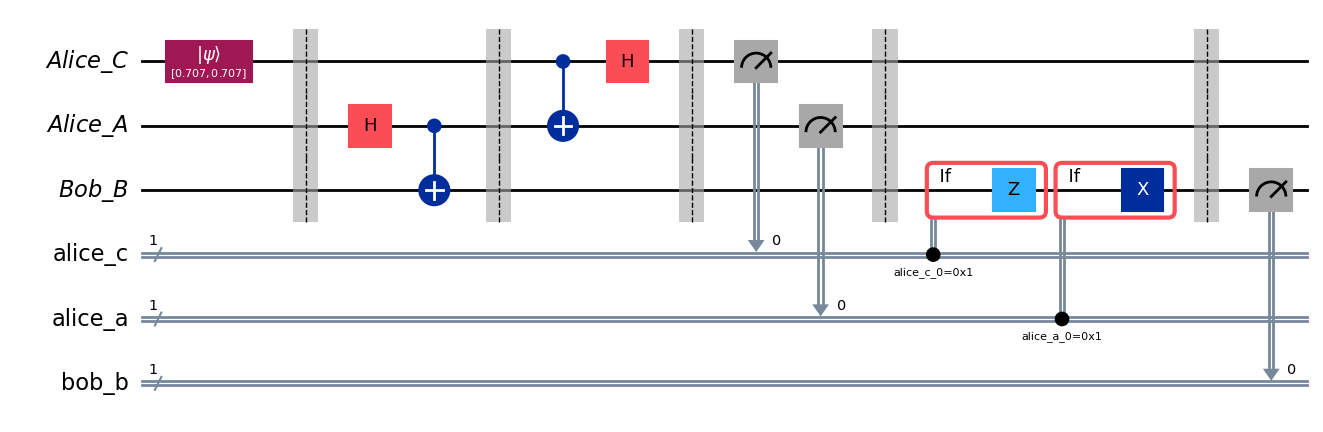

In [7]:
#Final measurement
qc.measure(qB[0],cB[0])

qc.draw("mpl")

## 8. Run on AerSimulator()

We use the Aer backend because it supports dynamic circuits like if_test.

{'0 0 1': 126, '1 1 0': 127, '1 1 1': 125, '1 0 0': 131, '1 0 1': 143, '0 1 1': 107, '0 0 0': 135, '0 1 0': 130}


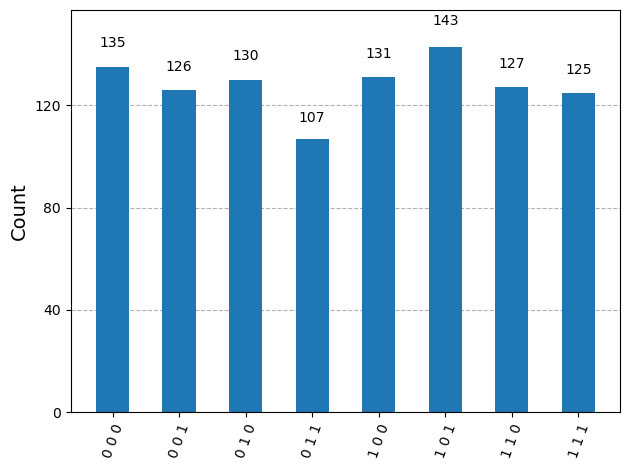

In [8]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
backend= AerSimulator()
qc_compile=transpile(qc, backend)
job= backend.run(qc_compile, shots=1024)
result=job.result()
counts= result.get_counts()
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

## Why Do We See 8 Possible Outcomes?

We measure 3 classical bits:

* Alice's cC → 1 bit
* Alice's cA → 1 bit
* Bob's cB → 1 bit

Total = 3 bits → 2³ = 8 outcomes.

Teleportation doesn't hide measurement bits; it requires them.

## Expected Behavior

Even though 8 outcomes appear, Bob’s final bit (last digit) follows:

* 0 for a teleported |0⟩ or |+⟩ measurement
* 1 for a teleported |1⟩ or |−⟩ measurement

The earlier two bits (Alice's) just represent which Bell-state branch occurred.